In [1]:
%matplotlib inline

In [2]:
import sys

In [3]:
sys.path.insert(0, '/home/tomault/projects/pegushi/src/python/packages')

In [4]:
import pegushi_gym.envs.maze

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
from pegushi_gym.envs.maze import FixedMazeEnvironment

In [6]:
import gym

In [7]:
from gym.utils.seeding import np_random

In [8]:
rng, seed = np_random(14045143762653964175L)

In [9]:
seed

14045143762653964175L

In [10]:
rng

In [11]:
maze5x5 = FixedMazeEnvironment(width = 5, height = 5, goal = (4, 4), rng = rng, seed = seed,
                               agent_image = '/home/tomault/projects/pegushi/src/resources/penguin24x24.png')

In [12]:
maze5x5.render('human')

In [13]:
import numpy as np

In [14]:
class TabularQFunction:
    """Implementation of Q function with a 3D tensor (x, y, action) with both hard and soft action selection
selection functions."""
    def __init__(self, q_table, rng):
        self.q_table = q_table
        self.num_actions = q_table.shape[-1]
        self.rng = rng
        
    def __call__(self, x, y, a):
        return self.q_table[x, y, a]
    
    def max_q(self, x, y):
        return np.max(self.q_table[x, y, :])
    
    def select_hard(self, x, y):
        """Select the action with the highest q-value and lowest action number"""
        return self.q_table[x, y, :].argmax()
    
    def select_soft(self, x, y):
        """Draw action from a categorical distribution whose parameters are computed from a softmax
           over the q-values for the given state."""
        q = self.soft_q_distribution(x, y)
        p = self.rng.uniform()
        
        # Assume action space is relatively small, so a linear search is not very inefficient
        # Otherwise, replace with a binary search
        for i in xrange(0, self.num_actions):
            if p < q[i]:
                return i
            p -= q[i]

        return self.num_actions - 1
    
    def soft_q_distribution(self, x, y):
        values = self.q_table[x, y, :]
        values = np.exp(values - np.max(values))
        return values / np.sum(values)
    
    def update(self, x, y, a, v, alpha = 1.0):
        u = self.q_table[x, y, a]
        self.q_table[x, y, a] = (1.0 - alpha) * u + alpha * v
        
    def copy(self):
        return TabularQFunction(self.q_table, self.rng)
    
    @staticmethod
    def zeros(q_function):
        return TabularQFunction(np.zeros(q_function.q_table.shape), q_function.rng)
    
    @staticmethod
    def from_maze_zeros(maze, rng):
        """Q-function for maze environment initialized to all zeros"""
        shape = (maze.observation_space.nvec[0], maze.observation_space.nvec[1], maze.action_space.n)
        q_table = np.zeros(shape)
        return TabularQFunction(q_table, rng)
    
    @staticmethod
    def from_maze_normal(maze, rng):
        """Q function for maze environment initialized with standard normal distribution"""
        shape = (maze.observation_space.nvec[0], maze.observation_space.nvec[1], maze.action_space.n)
        q_table = rng.normal(0.0, 1.0, size = shape)
        return TabularQFunction(q_table, rng)
        

In [15]:
class QLearner:
    def __init__(self, policy, alpha = 0.1, gamma = 0.5):
        # Q-function being learned
        self.q = policy
        
        # Learning rate
        self.alpha = alpha
        
        # Discount rate
        self.gamma = gamma
        
    def update(self, state, action, reward, next_state):
        t = self.target(reward, next_state)
        self.q.update(state[0], state[1], action, t, self.alpha)
        return self
        
    def update_trajectory(self, trajectory):
        """Trajectory is a sequence of (state, action, reward) tuples."""
        next_state = trajectory[-1][0]
        for (state, action, reward) in reversed(trajectory[0:-1]):
            self.update(state, action, reward, next_state)
            next_state = state
        return self
    
    def target(self, reward, next_state):
        future_rewards = self.gamma * self.q.max_q(*next_state) if next_state else 0.0
        return reward + future_rewards
        
        

In [16]:
qf = TabularQFunction.from_maze_zeros(maze5x5, rng)

In [17]:
qf.soft_q_distribution(0, 0)

array([0.25, 0.25, 0.25, 0.25])

In [18]:
from collections import Counter

In [19]:
def sample_trajectory(env, policy):
    state= env.reset()
    done = False
    trajectory = [ ]
    while not done:
        action = policy(*state)
        next_state, reward, done, _ = env.step(action)
        trajectory.append((state, action, reward))
        state = next_state
        
    trajectory.append((state, None, 0.0))
    return trajectory

In [20]:
t = sample_trajectory(maze5x5, lambda x, y: qf.select_soft(x, y))

In [21]:
len(t)

1193

In [22]:
sum(x[2] for x in t)

-3507.0

In [23]:
import time

In [24]:
def plot_trajectory(env, trajectory, delay = 0.5):
    for (state, action, reward) in trajectory:
        env.teleport(*state)
        env.render('human')
        time.sleep(delay)

In [25]:
plot_trajectory(maze5x5, t, 0.1)

In [26]:
learner = QLearner(qf, 1.0)

In [27]:
learner.update_trajectory(t)

<__main__.QLearner instance at 0x7f116a28b128>

In [28]:
def dump_action_distribution(qf):
    print ' X   Y  ACTION   NORTH    EAST     SOUTH    WEST'
    print '--- --- ------ -------- -------- -------- --------'
    for x in xrange(0, qf.q_table.shape[0]):
        for y in xrange(0, qf.q_table.shape[1]):
            a = qf.select_hard(x, y)
            p = qf.soft_q_distribution(x, y)
            print '%3d %3d %6d %8.6f %8.6f %8.6f %8.6f' % (x, y, a, p[0], p[1], p[2], p[3])

In [29]:
dump_action_distribution(qf)

 X   Y  ACTION   NORTH    EAST     SOUTH    WEST
--- --- ------ -------- -------- -------- --------
  0   0      0 0.952619 0.015794 0.015794 0.015794
  0   1      0 0.564429 0.008471 0.418630 0.008471
  0   2      0 0.635045 0.007809 0.349338 0.007809
  0   3      0 0.758081 0.006258 0.229402 0.006258
  0   4      1 0.003386 0.909906 0.083322 0.003386
  1   0      0 0.547162 0.416259 0.018289 0.018289
  1   1      0 0.635045 0.007809 0.349338 0.007809
  1   2      0 0.758081 0.006258 0.229402 0.006258
  1   3      0 0.909906 0.003386 0.083322 0.003386
  1   4      1 0.000743 0.982775 0.008241 0.008241
  2   0      3 0.008684 0.445390 0.008684 0.537243
  2   1      0 0.990200 0.008303 0.000749 0.000749
  2   2      0 0.999867 0.000031 0.000070 0.000031
  2   3      1 0.000000 1.000000 0.000000 0.000000
  2   4      2 0.000031 0.000031 0.999867 0.000070
  3   0      3 0.016361 0.016361 0.016361 0.950916
  3   1      3 0.003680 0.003680 0.003680 0.988960
  3   2      0 0.250000 0.250000 

In [30]:
rewards = [ ]

In [31]:
rewards.append(sum(x[2] for x in t))

In [32]:
rewards.append(sum(x[2] for x in t))

In [33]:
t = sample_trajectory(maze5x5, lambda x, y: qf.select_soft(x, y))

In [34]:
len(t)

11

In [35]:
rewards.append(sum(x[2] for x in t))

In [36]:
rewards

[-3507.0, -3507.0, 91.0]

In [37]:
plot_trajectory(maze5x5, t, delay = 0.5)

In [38]:
learner.update_trajectory(t)

<__main__.QLearner instance at 0x7f116a28b128>

In [39]:
dump_action_distribution(qf)

 X   Y  ACTION   NORTH    EAST     SOUTH    WEST
--- --- ------ -------- -------- -------- --------
  0   0      0 0.952619 0.015794 0.015794 0.015794
  0   1      0 0.564429 0.008471 0.418630 0.008471
  0   2      0 0.635045 0.007809 0.349338 0.007809
  0   3      0 0.758081 0.006258 0.229402 0.006258
  0   4      1 0.003386 0.909906 0.083322 0.003386
  1   0      0 0.547162 0.416259 0.018289 0.018289
  1   1      0 0.635045 0.007809 0.349338 0.007809
  1   2      0 0.758081 0.006258 0.229402 0.006258
  1   3      0 0.909906 0.003386 0.083322 0.003386
  1   4      1 0.000743 0.982775 0.008241 0.008241
  2   0      3 0.008684 0.445390 0.008684 0.537243
  2   1      0 0.990200 0.008303 0.000749 0.000749
  2   2      0 0.999867 0.000031 0.000070 0.000031
  2   3      1 0.000000 1.000000 0.000000 0.000000
  2   4      2 0.000031 0.000031 0.999867 0.000070
  3   0      3 0.016361 0.016361 0.016361 0.950916
  3   1      3 0.003680 0.003680 0.003680 0.988960
  3   2      0 0.250000 0.250000 

In [40]:
maze5x5.compute_solution_length()

10

In [41]:
t = sample_trajectory(maze5x5, lambda x, y: qf.select_soft(x, y))

In [42]:
len(t)

13

In [43]:
rewards.append(sum(x[2] for x in t))

In [44]:
plot_trajectory(maze5x5, t, delay = 0.5)

In [45]:
t

[((0, 0), 0, -1.0),
 ((0, 1), 0, -1.0),
 ((0, 2), 0, -1.0),
 ((0, 3), 0, -1.0),
 ((0, 4), 1, -1.0),
 ((1, 4), 3, -1.0),
 ((0, 4), 1, -1.0),
 ((1, 4), 1, -1.0),
 ((2, 4), 2, -1.0),
 ((2, 3), 1, -1.0),
 ((3, 3), 0, -1.0),
 ((3, 4), 1, 100.0),
 ((4, 4), None, 0.0)]

In [46]:
learner.update_trajectory(t)

<__main__.QLearner instance at 0x7f116a28b128>

In [47]:
dump_action_distribution(qf)

 X   Y  ACTION   NORTH    EAST     SOUTH    WEST
--- --- ------ -------- -------- -------- --------
  0   0      0 0.952619 0.015794 0.015794 0.015794
  0   1      0 0.564429 0.008471 0.418630 0.008471
  0   2      0 0.635045 0.007809 0.349338 0.007809
  0   3      0 0.758081 0.006258 0.229402 0.006258
  0   4      1 0.003386 0.909906 0.083322 0.003386
  1   0      0 0.547162 0.416259 0.018289 0.018289
  1   1      0 0.635045 0.007809 0.349338 0.007809
  1   2      0 0.758081 0.006258 0.229402 0.006258
  1   3      0 0.909906 0.003386 0.083322 0.003386
  1   4      1 0.000743 0.982775 0.008241 0.008241
  2   0      3 0.008684 0.445390 0.008684 0.537243
  2   1      0 0.990200 0.008303 0.000749 0.000749
  2   2      0 0.999867 0.000031 0.000070 0.000031
  2   3      1 0.000000 1.000000 0.000000 0.000000
  2   4      2 0.000031 0.000031 0.999867 0.000070
  3   0      3 0.016361 0.016361 0.016361 0.950916
  3   1      3 0.003680 0.003680 0.003680 0.988960
  3   2      0 0.250000 0.250000 

In [48]:
t = sample_trajectory(maze5x5, lambda x, y: qf.select_soft(x, y))

In [49]:
len(t)

17

In [50]:
rewards.append(sum(x[2] for x in t))

In [51]:
plot_trajectory(maze5x5, t, delay = 0.5)

In [52]:
rewards

[-3507.0, -3507.0, 91.0, 89.0, 85.0]

In [53]:
learner.update_trajectory(t)

<__main__.QLearner instance at 0x7f116a28b128>

In [54]:
dump_action_distribution(qf)

 X   Y  ACTION   NORTH    EAST     SOUTH    WEST
--- --- ------ -------- -------- -------- --------
  0   0      0 0.952619 0.015794 0.015794 0.015794
  0   1      0 0.564429 0.008471 0.418630 0.008471
  0   2      0 0.635045 0.007809 0.349338 0.007809
  0   3      0 0.758081 0.006258 0.229402 0.006258
  0   4      1 0.003386 0.909906 0.083322 0.003386
  1   0      0 0.547162 0.416259 0.018289 0.018289
  1   1      0 0.635045 0.007809 0.349338 0.007809
  1   2      0 0.758081 0.006258 0.229402 0.006258
  1   3      0 0.909906 0.003386 0.083322 0.003386
  1   4      1 0.000743 0.982775 0.008241 0.008241
  2   0      3 0.008684 0.445390 0.008684 0.537243
  2   1      0 0.990200 0.008303 0.000749 0.000749
  2   2      0 0.999867 0.000031 0.000070 0.000031
  2   3      1 0.000000 1.000000 0.000000 0.000000
  2   4      2 0.000031 0.000031 0.999867 0.000070
  3   0      3 0.016361 0.016361 0.016361 0.950916
  3   1      3 0.003680 0.003680 0.003680 0.988960
  3   2      0 0.250000 0.250000 

In [55]:
t

[((0, 0), 0, -1.0),
 ((0, 1), 0, -1.0),
 ((0, 2), 2, -1.0),
 ((0, 1), 2, -1.0),
 ((0, 0), 0, -1.0),
 ((0, 1), 0, -1.0),
 ((0, 2), 0, -1.0),
 ((0, 3), 2, -1.0),
 ((0, 2), 0, -1.0),
 ((0, 3), 0, -1.0),
 ((0, 4), 1, -1.0),
 ((1, 4), 1, -1.0),
 ((2, 4), 2, -1.0),
 ((2, 3), 1, -1.0),
 ((3, 3), 0, -1.0),
 ((3, 4), 1, 100.0),
 ((4, 4), None, 0.0)]

In [56]:
t = sample_trajectory(maze5x5, lambda x, y: qf.select_soft(x, y))

In [57]:
t

[((0, 0), 0, -1.0),
 ((0, 1), 2, -1.0),
 ((0, 0), 0, -1.0),
 ((0, 1), 2, -1.0),
 ((0, 0), 0, -1.0),
 ((0, 1), 0, -1.0),
 ((0, 2), 0, -1.0),
 ((0, 3), 0, -1.0),
 ((0, 4), 1, -1.0),
 ((1, 4), 1, -1.0),
 ((2, 4), 2, -1.0),
 ((2, 3), 1, -1.0),
 ((3, 3), 0, -1.0),
 ((3, 4), 1, 100.0),
 ((4, 4), None, 0.0)]

In [58]:
def learn(env, policy, num_iterations, alpha = 0.1, gamma = 0.5):
    learner = QLearner(policy, alpha, gamma)
    trajectories = [ ]
    for i in xrange(0, num_iterations):
        t = sample_trajectory(env, lambda x, y: policy.select_soft(x, y))
        trajectories.append((t, sum(x[2] for x in t)))
        learner.update_trajectory(t)
    return trajectories

In [59]:
maze16x16 = FixedMazeEnvironment(width = 16, height = 16, goal = (15, 15), rng = rng, seed = seed,
                                 agent_image = '/home/tomault/projects/pegushi/src/resources/penguin24x24.png')

In [87]:
policy_16x16 = TabularQFunction.from_maze_zeros(maze16x16, rng)
trajectories_16x16 = learn(maze16x16, policy_16x16, 1000, 1.0, 0.99)

In [88]:
rewards_16x16 = [x[1] for x in trajectories_16x16]

In [89]:
import matplotlib.pyplot as plt

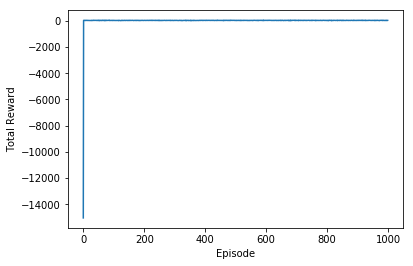

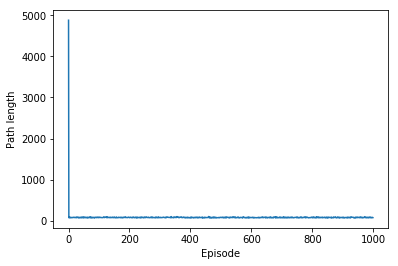

In [90]:
plt.plot(rewards_16x16)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

plt.plot(list(len(x[0]) for x in trajectories_16x16))
plt.xlabel('Episode')
plt.ylabel('Path length')
plt.show()

In [64]:
policy_5x5 = TabularQFunction.from_maze_zeros(maze5x5, rng)
trajectories_5x5 = learn(maze5x5, policy_5x5, 20, 1.0)

In [65]:
[x[1] for x in trajectories_5x5]

[-500.0,
 -249.0,
 89.0,
 75.0,
 86.0,
 84.0,
 89.0,
 87.0,
 91.0,
 72.0,
 91.0,
 91.0,
 89.0,
 89.0,
 89.0,
 91.0,
 80.0,
 73.0,
 91.0,
 89.0]

In [66]:
maze5x5.close()

In [67]:
maze16x16.render('human')

In [68]:
maze16x16.compute_solution_length()

64

In [80]:
plot_trajectory(maze16x16, trajectories_16x16[-2][0], 0.1)

In [93]:
[ len(trajectories_16x16[i][0]) for i in xrange(0, 50) ]

[4882,
 72,
 80,
 69,
 73,
 81,
 81,
 68,
 75,
 73,
 71,
 76,
 76,
 73,
 76,
 72,
 77,
 80,
 83,
 78,
 73,
 72,
 77,
 77,
 77,
 69,
 83,
 83,
 73,
 79,
 83,
 79,
 71,
 78,
 69,
 69,
 79,
 73,
 71,
 73,
 81,
 72,
 77,
 71,
 81,
 77,
 73,
 85,
 72,
 67]

In [ ]:
import matplotlib.pyplot as plt

In [92]:
dump_action_distribution(policy_16x16)

 X   Y  ACTION   NORTH    EAST     SOUTH    WEST
--- --- ------ -------- -------- -------- --------
  0   0      0 0.981352 0.006216 0.006216 0.006216
  0   1      1 0.005541 0.884287 0.104630 0.005541
  0   2      0 0.898581 0.091004 0.005208 0.005208
  0   3      1 0.082217 0.830808 0.082217 0.004759
  0   4      2 0.091004 0.005208 0.898581 0.005208
  0   5      2 0.005761 0.005761 0.982717 0.005761
  0   6      1 0.005181 0.984456 0.005181 0.005181
  0   7      1 0.005117 0.984648 0.005117 0.005117
  0   8      0 0.985220 0.004927 0.004927 0.004927
  0   9      0 0.867999 0.063858 0.063858 0.004284
  0  10      0 0.924730 0.004504 0.066262 0.004504
  0  11      0 0.926454 0.004452 0.064642 0.004452
  0  12      1 0.004401 0.928157 0.063042 0.004401
  0  13      0 0.986163 0.004612 0.004612 0.004612
  0  14      1 0.004297 0.931499 0.059907 0.004297
  0  15      1 0.004612 0.986163 0.004612 0.004612
  1   0      1 0.100664 0.888441 0.005447 0.005447
  1   1      2 0.005495 0.005495 

In [84]:
final_trajectory = sample_trajectory(maze16x16, lambda x, y: policy_16x16.select_hard(x, y))

In [85]:
len(final_trajectory)

65

In [86]:
plot_trajectory(maze16x16, final_trajectory, 0.1)

In [94]:
maze24x24 = FixedMazeEnvironment(width = 24, height = 24, goal = (23, 23), rng = rng, seed = seed,
                                 agent_image = '/home/tomault/projects/pegushi/src/resources/penguin24x24.png')

In [95]:
policy_24x24 = TabularQFunction.from_maze_zeros(maze24x24, rng)
trajectories_24x24 = learn(maze24x24, policy_24x24, 1000, 1.0, 0.99)

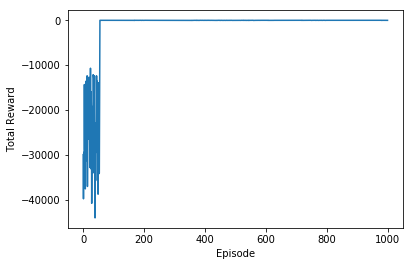

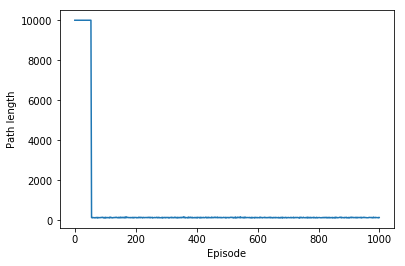

In [97]:
plt.plot(list(x[1] for x in trajectories_24x24))
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

plt.plot(list(len(x[0]) for x in trajectories_24x24))
plt.xlabel('Episode')
plt.ylabel('Path length')
plt.show()

In [98]:
maze24x24.compute_solution_length()

110

In [99]:
[ len(x[0]) for x in trajectories_24x24[50:70]]

[10001,
 10001,
 10001,
 10001,
 5254,
 130,
 125,
 121,
 125,
 137,
 127,
 127,
 125,
 125,
 121,
 129,
 119,
 122,
 119,
 131]